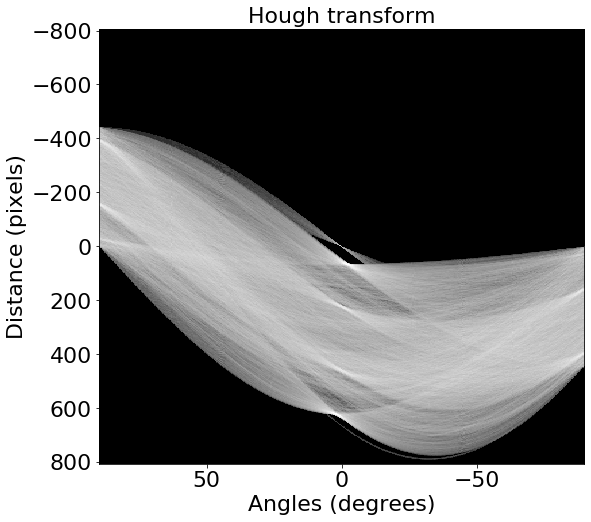

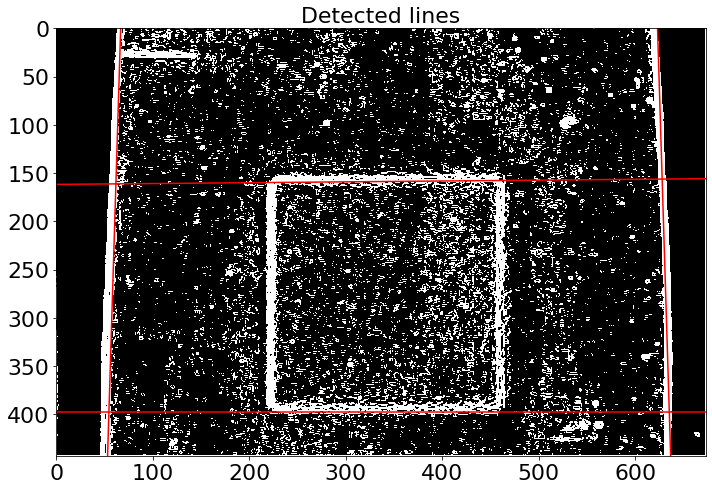

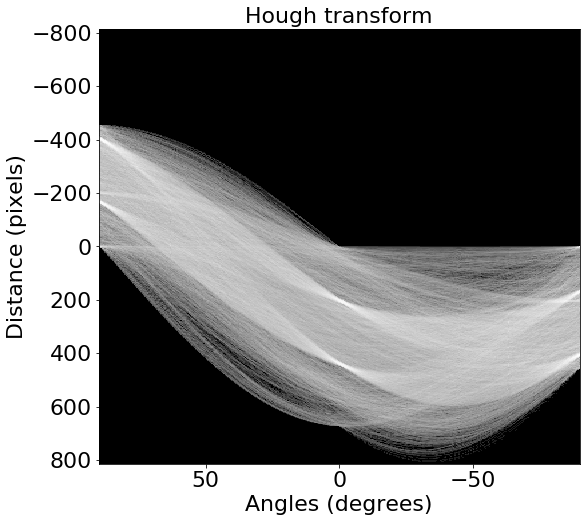

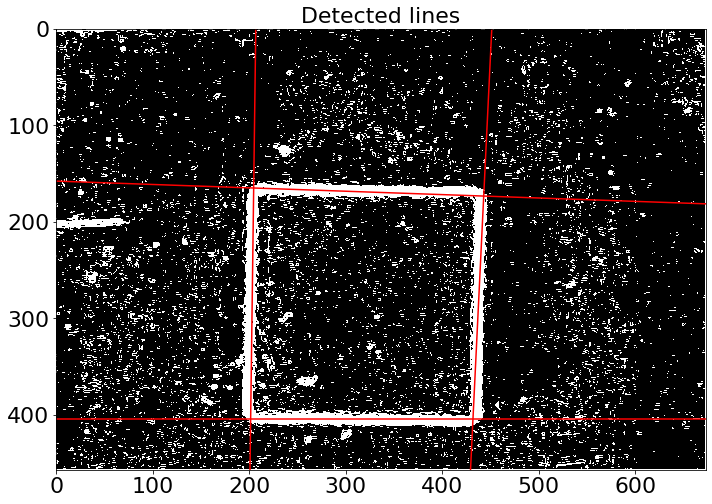

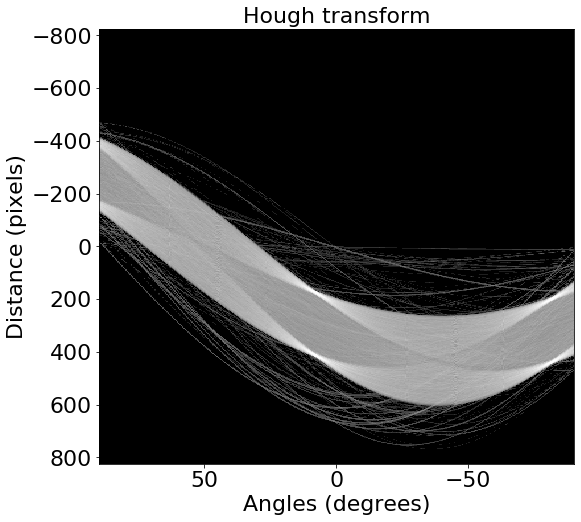

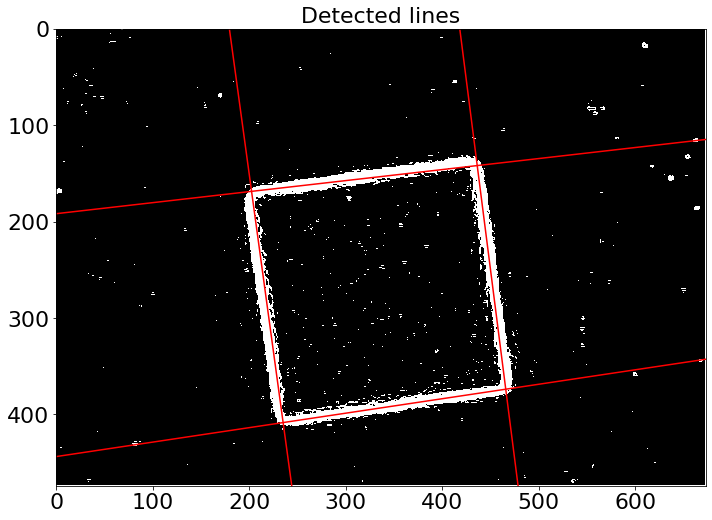

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import feature
import scipy
from scipy.stats import chisquare
from scipy.optimize import curve_fit
from scipy import stats
from scipy.optimize import least_squares
import cv2
import tifffile as tiff
import os
from scipy import signal
import time
from scipy.optimize import minimize
from scipy.stats import norm
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from matplotlib import cm
import argparse

filename = 'Calib_24hrs/Calibration_24hrs_'
#filename = 'Distance_Simulation/'
params = {'legend.fontsize': '22',
          'figure.figsize': (10, 8),
         'axes.labelsize': '22',
         'axes.titlesize':'22',
         'xtick.labelsize':'22',
         'ytick.labelsize':'22'}
plt.rcParams.update(params)
path, dirs, files = next(os.walk('Calib_24hrs/'))
#path, dirs, files = next(os.walk('Distance_Simulation/'))
file_count = np.arange(0,len(files),1)
numbers = ([1,2,3,4,5,6,8,10])
#doses = np.array([numbers, *[*zip(*[pixel_val(image_ret(i)) for i in numbers])]])

def snip(image,chop=2): return np.array([l[chop:-chop-1] for l in image[chop:-chop-1]])
    #This chops L R U D chop number of elements

def image_ret(file_num, col=0):
    full_img = tiff.imread(filename+str(file_num)+'.tiff')[:,:,col]
    #am inverting and changing mm.tiff 
    #full_img = np.invert(full_img)
    return snip(full_img)


#############################
# These are filters:

def sobel(image):
    Gx = signal.convolve(np.array([[-1,0,+1],[-2,0,+2],[-1,0,+1]]),image)
    Gy = signal.convolve(np.array([[-1,-2,-1],[0,0,0],[+1,+2,+1]]),image)
    G = np.sqrt(Gx**2+Gy**2)
    return snip(G)


def prewitt(image):
    Gx = signal.convolve(np.array([[1,1,1],[0,0,0],[-1,-1,-1]]),image)
    Gy = signal.convolve(np.array([[-1,0,1],[-1,0,1],[-1,0,1]]),image)
    G = np.sqrt(Gx**2+Gy**2)
    return snip(G)

def roberts(image):
    Gx = signal.convolve(np.array([[1,0],[0,-1]]),image)
    Gy = signal.convolve(np.array([[0,1],[-1,0]]),image)
    G = np.sqrt(Gx**2+Gy**2)
    return snip(G)
    
def smoothed_prewitt(image):
    Gx = signal.convolve(np.array([[-1,0,1],[-1,0,1],[-1,0,1]]),image)
    Gy = signal.convolve(np.array([[-1,-1,-1],[0,0,0],[1,1,1]]),image)
    G = np.sqrt(Gx**2+Gy**2)
    return snip(G)

def isotropic(image):
    Gx = signal.convolve(np.array([[-1,0,1],[-np.sqrt(2),0,np.sqrt(2)],[-1,0,1]]),image)
    Gy = signal.convolve(np.array([[-1,-np.sqrt(2),-1],[0,0,0],[1,np.sqrt(2),1]]),image)
    G = np.sqrt(Gx**2+Gy**2)
    return snip(G)

def laplace(image): return 0
    
    #not recommended for edge detection 

#from Fundamentals of Digital image processing - Anil. K. Jain 
    
def kirsch(image):
    Gx = signal.convolve(np.array([[3,3,-5],[3,0,-5],[3,3,-5]]),image)
    Gy = signal.convolve(np.array([[3,-5,-5],[3,0,-5],[3,3,3]]),image)
    G = np.sqrt(Gx**2+Gy**2)
    return snip(G)

def compass_gradient(image):
    Gx = signal.convolve(np.array([[1,1,-1],[1,-2,-1],[1,1,-1]]),image)
    Gy = signal.convolve(np.array([[1,1,-1],[1,-2,-1],[1,1,-1]]),image)
    G = np.sqrt(Gx**2+Gy**2)
    #dependent on direction you are trying to get line in 
    return snip(G)

#using definitions from Digital Image Processing - J.C.Simon, R.M.Haralick (Proceedings of NATO 1980)

def canny(image): return 0

#need to work on this

##############################

    
def line_eqn(line): 
    x0,x1,y0,y1 = line
    m = (y1-y0)/(x1-x0)
    c = y0
    return [m,c]

def plot_hough(h,theta,d):
    plt.imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray,aspect=1/10)
    plt.title('Hough transform')
    plt.xlabel('Angles (degrees)')
    plt.ylabel('Distance (pixels)')
    plt.show()
    
def hough_grid(image,base_thresh=0,thresh_step=0.1,peaks=4,sep=180):
    #am changing thresh_step
    thresh = base_thresh
    tested_angles = np.linspace(-np.pi/2, np.pi/2, 360)
    base_image = prewitt(image)
    image = np.where(base_image>thresh,1,0)
    h, theta, d = hough_line(image, theta=tested_angles)
    num_lines = len(hough_line_peaks(h, theta, d,min_distance=sep)[0])
    while num_lines != 4:
        if num_lines == 0:
            raise Exception("Could not find 4 lines in image")
        thresh += thresh_step
        image = np.where(base_image>thresh,1,0)
        h, theta, d = hough_line(image, theta=tested_angles)
        num_lines = len(hough_line_peaks(h, theta, d,min_distance=sep)[0])
    plot_hough(h,theta,d)
    plt.imshow(image, cmap=cm.gray)
    origin = np.array((0, image.shape[1]))
    lines = ([])
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d,min_distance=sep,num_peaks=peaks)):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        plt.plot(origin, (y0, y1), '-r')
        lines.append(line_eqn([origin[0],origin[1],y0,y1]))
    plt.xlim(origin)
    plt.ylim((image.shape[0],0))
    plt.title('Detected lines')
    plt.tight_layout()
    plt.show()
    return lines
    
def find_intercept(line1, line2):
    m1,c1 = line1
    m2,c2 = line2
    x = (c1-c2) / (m2-m1)
    y = m1 * x + c1
    return [x,y]    
    
def cross_points(image,lines):
    #takes lines and works out where they cross 
    #returns list of [x1,y1], [x2,y2]... of where points are
    done_list =([])
    pts = ([])
    for i in range(len(lines)):
        for j in range(len(lines)):
            if i!=j and not any(point in done_list for point in [[i, j], [j, i]]):
                done_list.append([i,j])
                p1,p2 = find_intercept(lines[i],lines[j])
                if 0<p1<image.shape[0] and 0<p2<image.shape[1]:
                    pts.append([int(p1),int(p2)])
    return pts

def plot_cross_points(image,lines):
    y = cross_points(image,lines)
    plt.imshow(image,cm.gray)
    plt.plot(*zip(*cross_points(image,lines)),'rx')
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.show()

def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    sqr = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    sqr[0] = pts[np.argmin(s)]
    sqr[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    sqr[1] = pts[np.argmin(diff)]
    sqr[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return sqr

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    #specifying points
    # top-left, top-right, bottom-right, and bottom-left
    sqr = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
        # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, sqr)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped


def pixel_val(warped): #takes warped image and 
    in_avg, in_std= np.mean(warped),np.std(warped)/np.sqrt(len(warped))
    return ([in_avg,in_std])



def image_doses(numbers): #takes the image locations and returns [image_locations,pixel_vals,pixel_val_std]
    doses = np.array([numbers, *[*zip(*[pixel_val(four_point_transform(image_ret(i), \
            np.array(cross_points(image_ret(i),hough_grid(image_ret(i)))))) for i in numbers])]])
    return doses

def pv(x,pv_min,pv_max,b,d_0): return (pv_min + (pv_max-pv_min))/((1+10**(-1*b*(np.log(d_0)-np.log(x))))) 

def optical_density(pixel_val): return np.log10(np.array(256)/np.array(pixel_val))


doses = image_doses(numbers)
OD = optical_density(doses[1])
plt.plot(doses[0],OD,'b.',label=r'OD equation: $OD = log_{10}\left(\frac{I_{0}}{I}\right)$')
def poly(x,a,b):return a*x+b
popt, pcov = scipy.optimize.curve_fit(poly,doses[0],OD,p0=[0.026,0.12],sigma=np.log10(256)*(-np.log(10)*doses[2])/(doses[1]*(np.log(doses[1]))**2))
perr = np.sqrt(np.diag(pcov))
chi_fit = chisquare(OD,[poly(i,*popt) for i in doses[0]])[0]
slope, intercept, r_value, p_value, std_err = stats.linregress(doses[0],OD)
plt.errorbar(x=doses[0],y=OD,xerr=0.01, yerr=np.log10(256)*(-np.log(10)*doses[2])/(doses[1]*(np.log(doses[1]))**2),ls='None')
plt.plot(doses[0],[poly(i,*popt) for i in doses[0]],label=r'Fit equation = $ax+b$')
print('a={:.3f} pm {:.3f}, b={:.3f} pm {:.3f}, chi-sqr={:.3f}'.format(popt[0],perr[0],popt[1],perr[1],chi_fit))
plt.title("OD value vs Dose to H20")
plt.xlabel("Dose to H2O (Gy)")
plt.ylabel("OD value")
plt.show()


popt, pcov = scipy.optimize.curve_fit(pv,doses[0],doses[1],p0=[1,120,1,3.5],sigma=doses[2])
chi_fit = chisquare(doses[1],[pv(i,*popt) for i in doses[0]])[0]
print('pv_min={:.3f}, pv_max={:.3f}, b={:.3f}, d_0={:.3f} and chi-sqr={:.3f}'.format(popt[0],popt[1],popt[2],popt[3],chi_fit))
plt.plot(doses[0],doses[1],'.',label='Data')
plt.errorbar(x=doses[0],y=doses[1],xerr=0.01, yerr=doses[2],ls='None')
plt.title("Pixel value for GafChromic film vs Dose to H20")
plt.xlabel("Dose to H2O (Gy)")
plt.ylabel("Pixel value")
x = np.linspace(0,len(doses[0]),100)
plt.plot(x,pv(x,*popt),'r-',label=r'Green Saunders: $pv_{min}+\frac{pv_{max}-pv_{min}}{1+10^{-b(log(d_{0})-log(x))}}$')
plt.legend()
plt.show()

plt.plot(OD,doses[1],'b.',label='Data')
def fit_OD_pv(OD,a,b):return a*np.exp(b*OD)
popt, pcov = scipy.optimize.curve_fit(fit_OD_pv,OD,doses[1],p0=[1,1],sigma=doses[2])
chi_fit = chisquare(doses[1],[fit_OD_pv(i,*popt) for i in OD])[0]
print('a={:.3f}, b={:.3f}, chi-sqr={:.3g}'.format(popt[0],popt[1],chi_fit))
plt.plot(OD,fit_OD_pv(OD,*popt),'r-',label=r'Fit equation: $ae^{b\cdot OD}$')
plt.errorbar(x=OD,y=doses[1],yerr=doses[2],xerr=np.log10(256)*(-np.log(10)*doses[2])/(doses[1]*(np.log(doses[1]))**2),ls='None')
plt.title("Pixel vs OD value for GafChromic film")
plt.xlabel("OD value")
plt.ylabel("Pixel value")
plt.legend()
plt.show()

def plot_roi(image,pts): #
    warped = four_point_transform(image, pts)
    plt.imshow(warped)
    plt.show()

#Need to credit https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/

In [63]:
print(len(doses[0]))
#going to need to make this value the max in the list returned by the get_file_nums
#also need to do dark subtraction at some point

'''def find_bckgr(image):
    bckgr_l=([])
    bckgr_r=([])
    image = image[2:400,2:510]
    k = np.arange(image.shape[0])
    l = np.arange(image.shape[1])
    
    for j in l:
        for i in k:
            if image[i,j]==0:
                bckgr_l.append(tuple([i+2,j+2]))
            elif image[i,j]==1:
                j+=1
                
    for j in l[::-1]:
        for i in k[::-1]:
            if image[i,j]==0:
                bckgr_r.append(tuple([i+2,j+2]))
            elif image[i,j]==1:
                j-=1
    bckgr = ([])
    bckgr = np.array(tuple(set(bckgr_r)|set(bckgr_l)))
    bckgr = np.array([[bckgr[i][0] for i in range(len(bckgr))],[bckgr[i][1] for i in range(len(bckgr))]])
    return bckgr
bckgr = find_bckgr(G)
plt.scatter(bckgr[1],bckgr[0],marker='o')
plt.plot(G[bckgr[0]][bckgr[1]])
plt.show()
'''

'''
def peak_find(array):
    i,peak_num = 1,3
    while peak_num!=2:
        peak_num = len(scipy.signal.argrelextrema(array, np.greater,order=i)[0])
        i+=round((peak_num/i)+1)
    return scipy.signal.argrelextrema(array, np.greater,order=i)[0]

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)
    
    
    
    xscan = 200
    yscan = 200
    expected=(120,2,5000,200,1,25000)
    params,cov=curve_fit(bimodal,x,y,expected)
    plt.plot(x,bimodal(x,*params),color='red',lw=3,label='model')
    plt.hist(H,bins=500)
    plt.show()
    #plt.plot(S[2,2:500])
    #plt.plot(S[200,2:500])
    #plt.show()
    peak = peak_find(S[xscan,2:500])
    peak1 = peak_find(S[2:400,yscan])
    plt.title('Prewitt filtered image')
    plt.axhline(yscan,0,a.shape[1],color='r')
    plt.axvline(xscan,0,a.shape[0],color='g')
    plt.plot(peak,[yscan,yscan],'bx',markersize=20,label='peak positions')
    plt.plot([xscan,xscan],peak1,'bx',markersize=20,label='peak positions')
    plt.imshow(S,cmap='gray')

    plt.xlabel('x axis')
    plt.ylabel('y axis')
    plt.show()
    plt.xlabel('y axis')
    plt.ylabel('Pixel Value')
    plt.plot(S[2:400,xscan],'g.')
    plt.plot(peak1,S[peak1,yscan],'bx',markersize=20,label='peak positions')
    plt.legend()
    plt.show()

    plt.xlabel('x axis')
    plt.ylabel('Pixel Value')
    plt.plot(S[yscan,2:500],'r.')
    plt.plot(peak,S[xscan,peak],'bx',markersize=20,label='peak positions')
    plt.legend()
    plt.show()

'''

8


"\ndef peak_find(array):\n    i,peak_num = 1,3\n    while peak_num!=2:\n        peak_num = len(scipy.signal.argrelextrema(array, np.greater,order=i)[0])\n        i+=round((peak_num/i)+1)\n    return scipy.signal.argrelextrema(array, np.greater,order=i)[0]\n\ndef gauss(x,mu,sigma,A):\n    return A*np.exp(-(x-mu)**2/2/sigma**2)\n\ndef bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):\n    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)\n    \n    \n    \n    xscan = 200\n    yscan = 200\n    expected=(120,2,5000,200,1,25000)\n    params,cov=curve_fit(bimodal,x,y,expected)\n    plt.plot(x,bimodal(x,*params),color='red',lw=3,label='model')\n    plt.hist(H,bins=500)\n    plt.show()\n    #plt.plot(S[2,2:500])\n    #plt.plot(S[200,2:500])\n    #plt.show()\n    peak = peak_find(S[xscan,2:500])\n    peak1 = peak_find(S[2:400,yscan])\n    plt.title('Prewitt filtered image')\n    plt.axhline(yscan,0,a.shape[1],color='r')\n    plt.axvline(xscan,0,a.shape[0],color='g')\n    plt.plot(peak,[yscan,yscan],'